In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import sys
sys.path.append("../analysis/")
sys.path.append("../dsc/functions/")

import utils
import methodprops
import plot_functions as fplot
import simulate

from gradvi.models import basis_matrix as gv_basemat
from gradvi.optimize import moving_average as gvma
from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR

In [2]:
n = 1024
sfix = 4
snr  = 5.0
degree = 0
x = np.linspace(0, 1, n)

y, ytest, ytrue, btrue, strue = simulate.timeseries(x, sfix, degree, snr)

In [3]:
H = gv_basemat.trendfiltering(n, degree)
Hinv = gv_basemat.trendfiltering_inverse(n, degree)
Hscale = gv_basemat.trendfiltering_scaled(n, degree)
Hinvscale = gv_basemat.trendfiltering_inverse_scaled(n, degree)
b_linreg = np.dot(Hinv, ytrue)
b_linreg[np.abs(b_linreg) <= 1e-8] = 0.

In [4]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



R[write to console]: Loading required package: Matrix



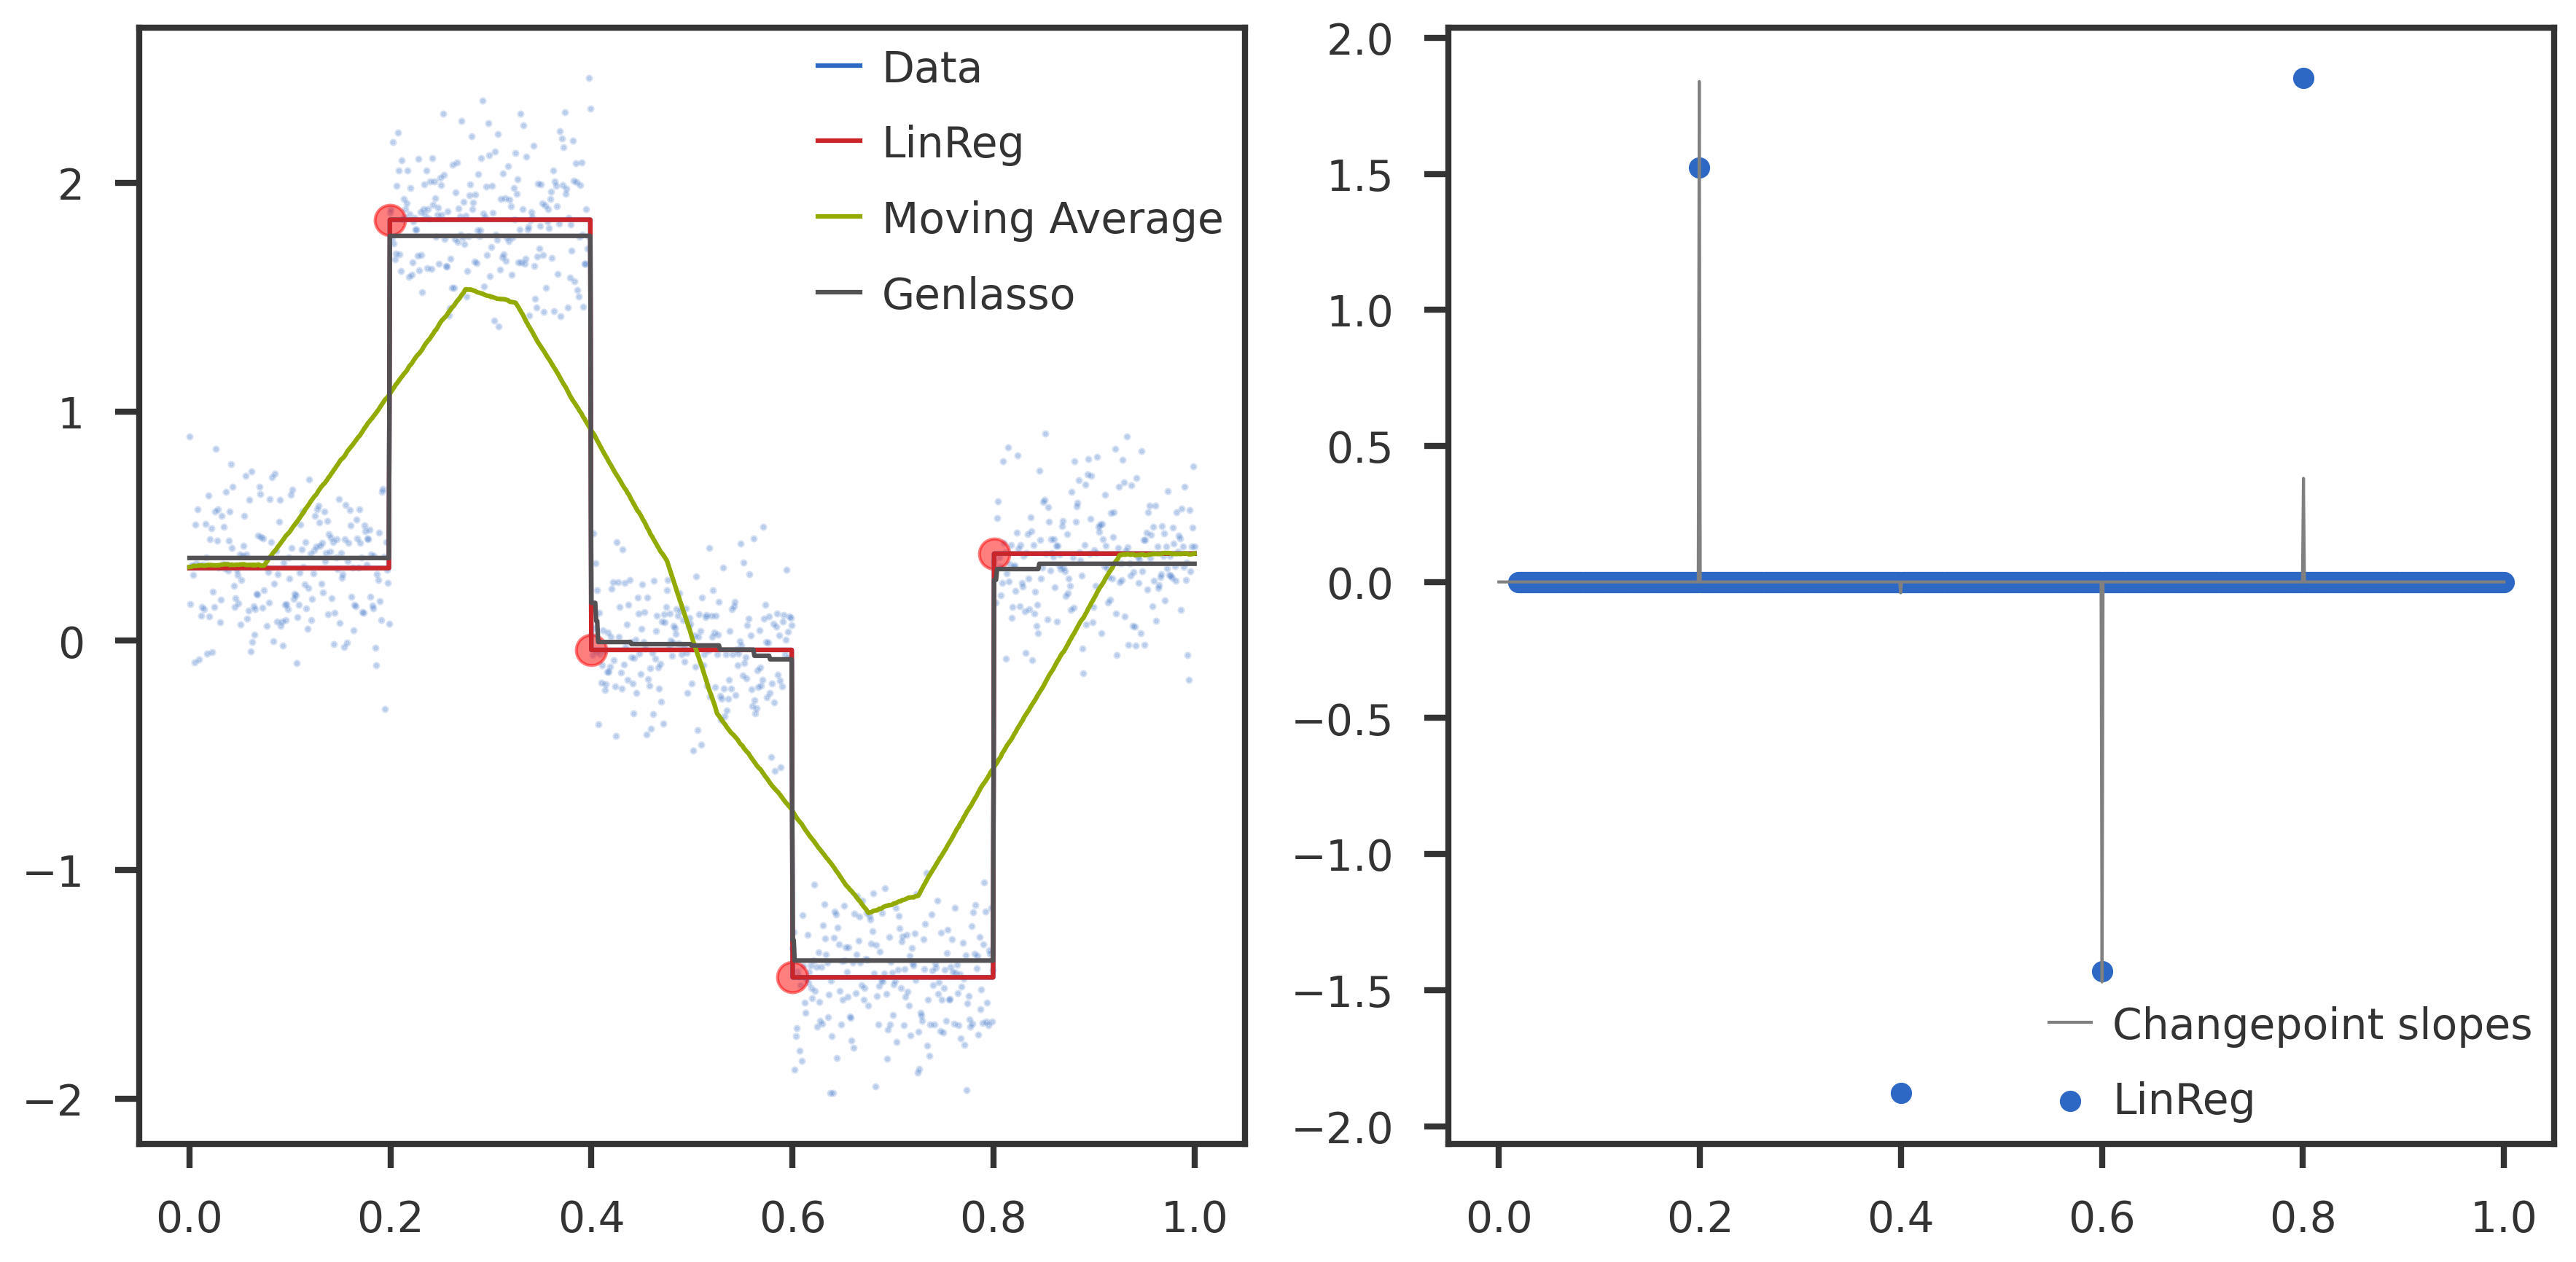

In [5]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y_init = gvma.moving_average(y, n = 256)

ax1.scatter(x, y, s = 2, alpha = 0.2)
ax1.plot (x, ytrue, label = 'Data')
for i, b in enumerate(btrue):
    if b != 0: ax1.scatter(x[i], ytrue[i], s = 100, c = 'red', marker = 'o', alpha = 0.5)
ax1.plot(x, np.dot(H, b_linreg), label = 'LinReg')
ax1.plot(x, y_init, label = 'Moving Average')
ax1.plot(x, tf_y, label = 'Genlasso')
ax1.legend()

ax2.plot(x, btrue, label = 'Changepoint slopes', lw = 1, c = 'grey')
ax2.scatter(x[20:], b_linreg[20:], label = 'LinReg')
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
import fit_gradvi
from gradvi.inference import Trendfiltering

# Prior definitions
skfactor = (degree + 1) * 20.0
ncomp = 20
sparsity = 0.99
skbase = 2.0
prior_init = fit_gradvi.get_ash(k = ncomp, sparsity = sparsity, skbase = skbase, skfactor = skfactor)

gv_compound_scaled = Trendfiltering(
        obj = 'reparametrize', maxiter = 2000, tol = 1e-8, 
        standardize_basis = True, scale_basis = False, 
        standardize = True)
gv_compound_scaled.fit(y, degree, prior_init)

In [7]:
mrash_r = MrASHR(option = "rds", debug = True)
mrash_r.fit(Hscale, y, prior_init.sk,
            binit = np.dot(Hinvscale, y_init),
            winit = prior_init.w_init, 
            s2init = np.var(y - y_init))

2023-07-05 18:00:47,701 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 768.



In [8]:
mrash_r_ypred = np.dot(Hscale, mrash_r.coef.reshape(-1,)) + mrash_r.intercept

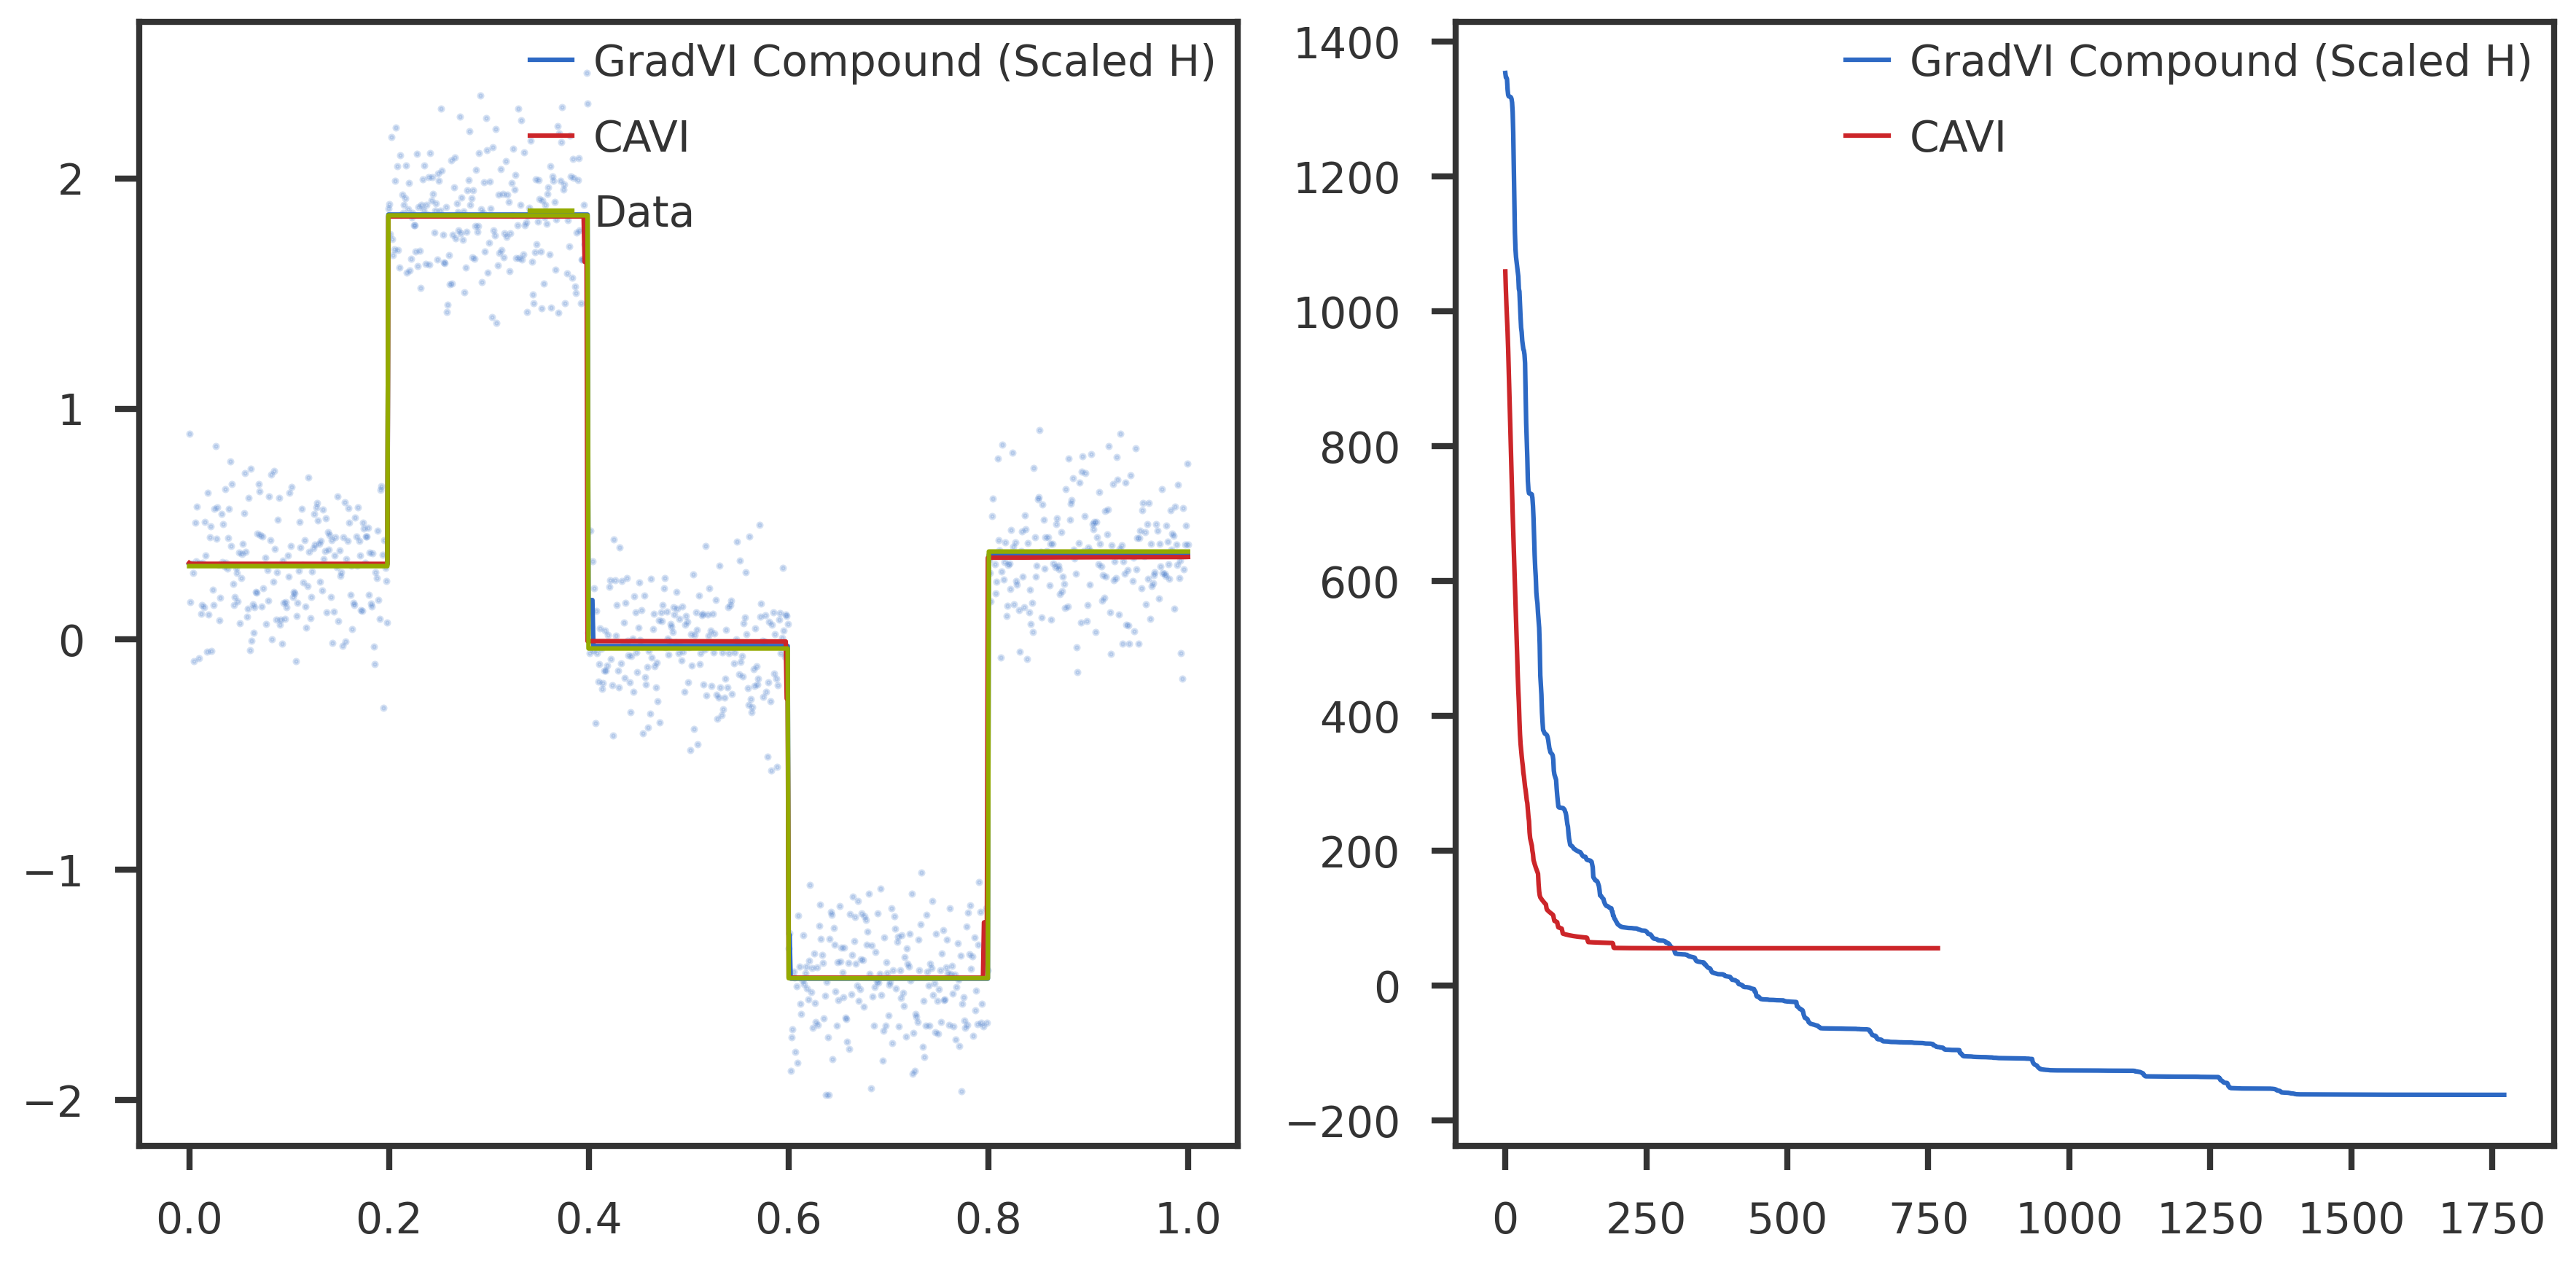

In [9]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, s = 2, alpha = 0.2)
ax1.plot(x, gv_compound_scaled.ypred, label = 'GradVI Compound (Scaled H)')
ax1.plot(x, mrash_r_ypred, label = 'CAVI')
ax1.plot(x, ytrue, label = 'Data')
#ax1.plot(x, tf_y, label = 'Genlasso')
ax1.legend()

ax2.plot(np.arange(gv_compound_scaled.elbo_path.shape[0]), gv_compound_scaled.elbo_path, label = 'GradVI Compound (Scaled H)')
ax2.plot(np.arange(mrash_r.elbo_path.shape[0]), mrash_r.elbo_path, label = 'CAVI')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
def get_elbo_from_mrash(gvcls, y):
    n = y.shape[0]
    degree = gvcls._tf_degree
    prior_sk = gvcls.prior.sk
    prior_wk = gvcls.prior.w
    y_opt = gvcls.ypred
    s2_opt = gvcls.residual_var
    
    X = gv_basemat.trendfiltering(n, degree)
    Xinv = gv_basemat.trendfiltering_inverse(n, degree)
    b_opt = np.dot(Xinv, y_opt)
    
    # Run Mr.Ash
    mrash_r = MrASHR(option = "rds")
    mrash_r.fit(X, y, prior_sk,
                binit = b_opt,
                winit = prior_wk, 
                s2init = s2_opt,
                maxiter = 1,
                update_pi = False, 
                update_sigma2 = False)
    return mrash_r.elbo_path[0]

In [25]:
get_elbo_from_mrash(gv_compound_scaled, y)

2023-07-05 18:14:39,879 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 1.



-81.06592184017921

In [18]:
gv_compound_scaled.elbo_path[-1]

-162.04547074104786

In [26]:
from gradvi.priors import Ash
_cavi_prior = Ash(prior_init.sk, wk = mrash_r.prior.reshape(-1,), scaled = False)

In [27]:
gv_init = Trendfiltering(
        obj = 'reparametrize', maxiter = 2000, tol = 1e-8,
        optimize_b = True, optimize_s = True, optimize_w = True,
        standardize_basis = False, scale_basis = False, 
        standardize = False)
gv_init.fit(y, degree, _cavi_prior, y_init = mrash_r_ypred)

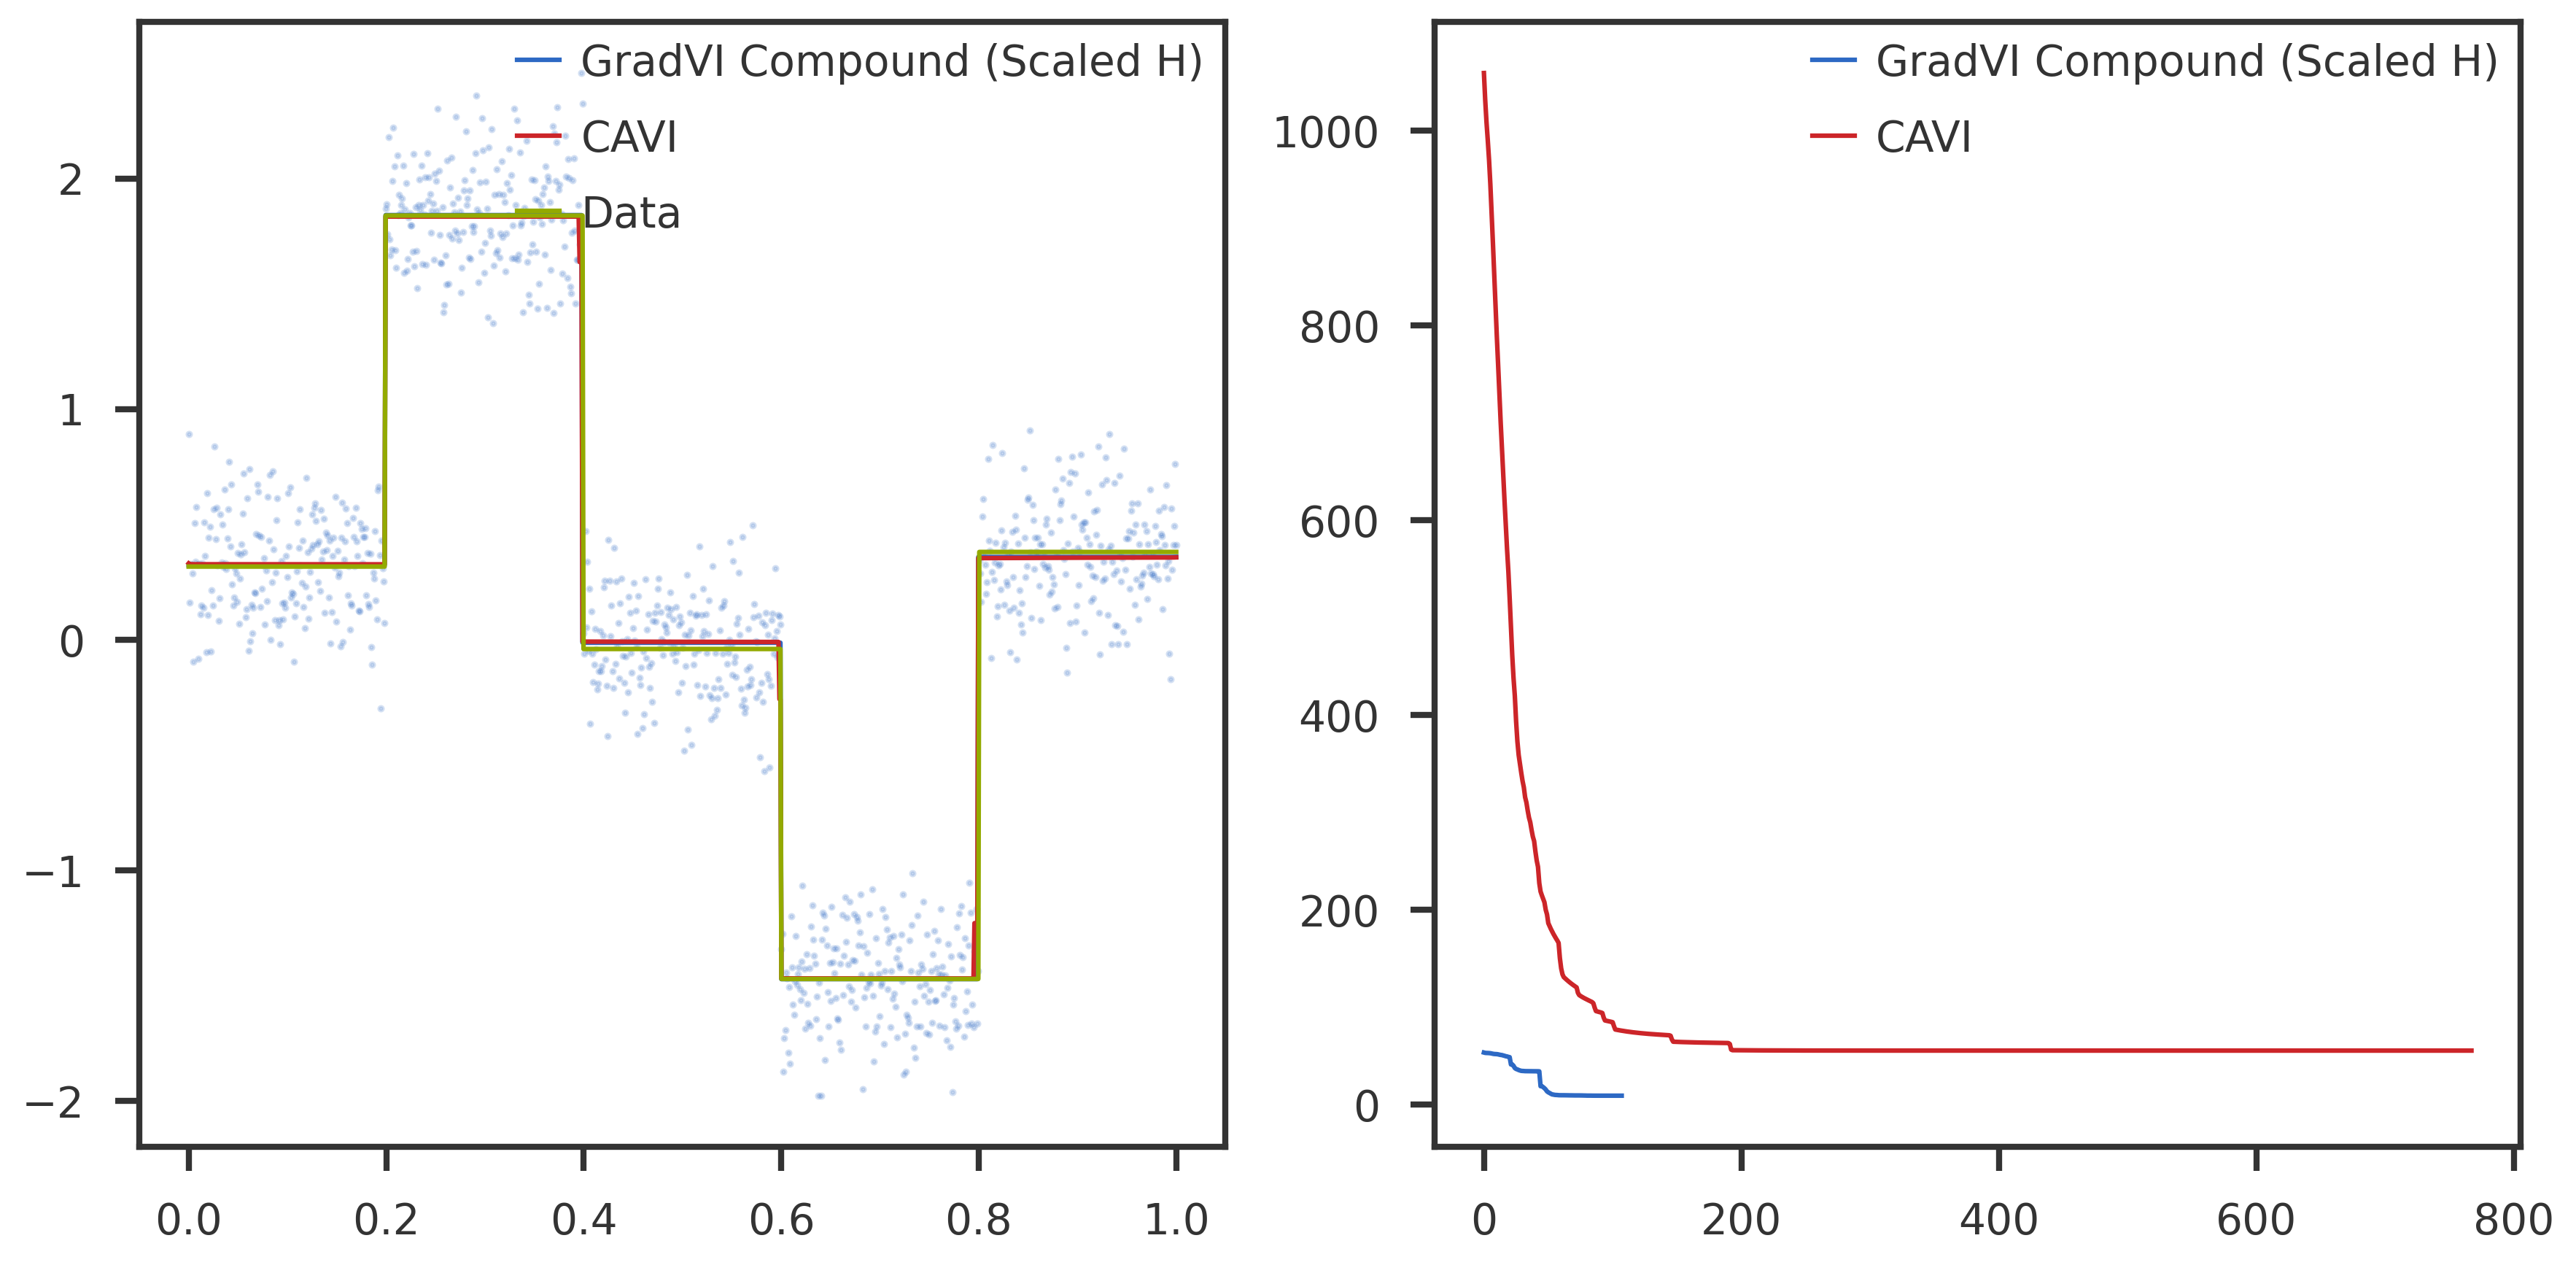

In [28]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, s = 2, alpha = 0.2)
ax1.plot(x, gv_init.ypred, label = 'GradVI Compound (Scaled H)')
ax1.plot(x, mrash_r_ypred, label = 'CAVI')
ax1.plot(x, ytrue, label = 'Data')
#ax1.plot(x, tf_y, label = 'Genlasso')
ax1.legend()

ax2.plot(np.arange(gv_init.elbo_path.shape[0]), gv_init.elbo_path, label = 'GradVI Compound (Scaled H)')
ax2.plot(np.arange(mrash_r.elbo_path.shape[0]), mrash_r.elbo_path, label = 'CAVI')
ax2.legend()

plt.tight_layout()
plt.show()

In [46]:
from gradvi.models import TrendfilteringModel
from gradvi.normal_means import NormalMeansFromPosterior

dj = np.sum(np.square(Hscale), axis = 0)
b_init = mrash_r.coef.reshape(-1,)
nm = NormalMeansFromPosterior(b_init, _cavi_prior, mrash_r.residual_var / dj,
                              scale = mrash_r.residual_var, d = dj)
theta_init = nm.response


tfmodel = TrendfilteringModel(Hscale, y, b_init, mrash_r.residual_var, _cavi_prior,
                              objtype = 'direct', debug = True,
                              tfbasis_matrix = Hscale, tf_degree = 0)

In [47]:
tfmodel.elbo(method = 'mrash')

55.43331284097776

In [48]:
tfmodel.objective

2023-07-05 18:31:38,162 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash prior
2023-07-05 18:31:38,164 | gradvi.models.linear_model               | DEBUG   | Residual variance = 0.05780206426280299


2550811.0394468573

In [34]:
tfmodel2 = TrendfilteringModel(H, y, b_init, mrash_r.residual_var, _cavi_prior,
                              objtype = 'direct', debug = True,
                              tfbasis_matrix = H, tf_degree = 0)
tfmodel2.objective

2023-07-05 18:26:09,880 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash prior
2023-07-05 18:26:09,881 | gradvi.models.linear_model               | DEBUG   | Residual variance = 0.05780206426280299


2547810.813327439

In [35]:
tfmodel2.elbo()

2160542.324194248

In [36]:
gv_compound_scaled.ypred

array([0.32775628, 0.32454862, 0.32452591, ..., 0.36799491, 0.36805357,
       0.3680554 ])

In [38]:
mrash_r_init = MrASHR(option = "rds", debug = True)
mrash_r_init.fit(H, y, prior_init.sk,
            binit = np.dot(Hinv, gv_compound_scaled.ypred),
            winit = gv_compound_scaled.prior.w, 
            s2init = gv_compound_scaled.residual_var, 
            maxiter = 2)

2023-07-05 18:26:32,237 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 2.



In [39]:
mrash_r_init.elbo_path

array([-82.40904298, -82.55821972])

In [40]:
mrash_r.elbo_path[-1]

55.42635326711511